# Análise de Estratégias para Valores Textuais

O objetivo deste *notebook* é analisar estratégias para se lidar com valores textuais. São 4 atributos textuais disponíveis, dos quais um possui apenas 6 valores (*category*) e os demais possuem textos mais longos, especialmente *tags*.

As categorias possuem duas formas diferentes de uso, conforme a etapa do projeto:
 - **Supervisionada**: funciona como o rótulo das instâncias, então deve ser processada com algo equivalente ao *LabelEncoder*.
 - **Não Supervisionada**: pode ser utilizada como *feature* para o modelo de intenção de busca. Nesse caso, espera-se trabalhar com uma de duas opções:
    - *One Hot Encoding*, para se ter 5 *features* no vetor de caracerísticas
    - Alguma variação de *target encoding* (e.g., *leave one out*, catboost ou *mean target encoding*). Nesse caso, o número de *features* adicionais dependerá do número de intenções de busca identificadas. Caso o número seja superior a 5, OHE pode ser a opção mais prática.

Para os 3 atributos com valores textuais mais longos, as abordagens propostas inicialmente são:
 - Usar o modelo tradicional de TF-IDF: pode ser usado em conjunto com *n-grams* para estabelecer sequência entre termos (pode ser útil para título, *tags* e busca), mas parece ser mais suscetível a problemas com palavras ausentes do vocabulário. Provavelmente levará a um número maior de atributos no vetor de características, mas podem ser feitas podas ou redução de dimensionalidade.
 - Usar *embeddings*: se beneficia da variedade mais ampla de palavras a partir da qual o modelo foi criado, reduzindo o problema de palavras fora do vocabulário. A depender do algoritmo e as estratégias de criação do modelo, provavelmente já incorpora informações adicionais de contexto e relação entre as palavras. Tende a ter entre 300 e 768 atributos adicionais no vetor de cacterísticas, ainda que seja possível adotar estratégias de redução.

Considerando o problema em potencial de se ter palavras fora do vocabulário, seja por produtos novos ou por estar baseado em personagem novo de filme, ou ter erros de grafia, é interessante usar *embeddings* que tenham sido criados a partir de um escopo amplo de dados. Assim, a abordagem inicial adotada será esta.

TODO (ou devaneios):
 - Experimentar aumentação de dados a partir do título (importante para o modelo não supervisionado);
 - Comparar o tamanho do vetor de características dos *embeddings* com OHE + TF-IDF;
 - Fazer avaliações de similaridade e busca usando as abordagens em teste
     - Uma estratégia de validação pode ser a correlação entre a página de busca + posição de produtos com a mesma busca com a ordem retornada pela estratégia de trabalho com texto. A busca que deu origem à ordem certamente tem mais recursos, e também não é possível garantir que as buscas sejam da mesma pessoa, mas é algum indício.
 - Avaliar a necessidade de usar pré-processamentos adicionais de texto para o fasttext;
 - Reduzir tamanho dos *embeddings* e verificar mudanças em eficácia e eficiência;
 - Avaliar *embeddings* do BERTimbau;

## Bibliotecas e Funções

In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import sys
from pathlib import Path

# Programação funcional e utilitários
import funcy as fp
import itertools

# Recursos para texto
import re

# Verificação de tipos
from typing import List

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Manipulação e análise de texto
import fasttext

# Redução de Dimensionalidade e Análise de Similaridade
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(str(Path.cwd().parent))
from src import settings
from src.utils.text import SPLIT_PATTERN
from src.utils.notebooks import display_side_by_side
from src.utils.experiments import set_dataset_split, extract_tokens
from src.utils.experiments import compute_multiclass_classification_metrics

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

## Carregamento dos Dados

Para analisar os dados e fazer algumas experimentações, as colunas com valores textuais serão recuperadas, assim como outras que auxiliam na experimentação (como a data de criação). Os dados utilizados se limitam ao conjunto de treinamento, mantendo o isolamento dos dados de teste.

In [2]:
columns_to_read = ['product_id', 'query', 'search_page', 'position', 'title', 'concatenated_tags', 'category', 'creation_date']

frame = pd.read_csv(str(Path(settings.DATA_PATH).joinpath('interim', 'training.csv')), usecols=columns_to_read)

Visualização da quantidade de registros e das informações disponíveis.

In [3]:
print(f'Registros: {len(frame)}.')

frame.head(10)

Registros: 32746.


product_id                                query  search_page  position  \
0    11394449                       espirito santo            2         6   
1    15534262                     cartao de visita            2         0   
2    15877252  medidas lencol para berco americano            1         6   
3    15917108                 adesivo box banheiro            3        38   
4     4336889                         dia dos pais            1        37   
5     7544556          arranjo de flores para mesa            1         9   
6    10869150             lembrancinha maternidade            5        18   
7    13193769                chaveiro dia dos pais            1        35   
8    13424151                  manta personalizada            1        20   
9    12595651                                 pais            1        28   

                                                  title  \
0                                Mandala Espírito Santo   
1                                      Cartão de Visita   
2                        Jogo de Lençol Berço Estampado   
3                               ADESIVO BOX DE BANHEIRO   
4                      Álbum de figurinhas dia dos pais   
5                         Arranjo de Flores - Orquidias   
6  Kit Aromarizador + sacola / Lembrancinha Maternidade   
7                                 chaveiro dia dos pais   
8       Manta para bebê personalizada de Nuvem com nome   
9                                  Chinelo Dia dos Pais   

                                                                                concatenated_tags  \
0                                                                                     mandala mdf   
1                                   cartao visita panfletos tag adesivos copos long drink canecas   
2                                                               t jogo lencol menino lencol berco   
3                                                                            adesivo box banheiro   
4                                                         albuns figurinhas pai lucas album fotos   
5                                                                                   mini arranjos   
6  bb lembrancinhas maternidade baby lembranca maternidade bebe conforto lembrancinha maternidade   
7                                                                                        dia pais   
8                                                     nascimento manta baby cha bebe vestido bebe   
9                                                                               sandalia dia pais   

         creation_date       category  
0  2015-11-14 19:42:12      Decoração  
1  2018-04-04 20:55:07    Papel e Cia  
2  2017-02-27 13:26:03           Bebê  
3  2017-05-09 13:18:38      Decoração  
4  2018-07-11 10:41:33  Lembrancinhas  
5  2016-04-22 13:34:16      Decoração  
6  2017-10-05 00:26:02  Lembrancinhas  
7  2018-07-04 12:47:49  Lembrancinhas  
8  2018-04-03 16:10:51           Bebê  
9  2018-06-25 23:23:14  Lembrancinhas

## Word2Vec (via FastTex)

Esta seção explora o uso de uma implementação [work2vec](https://arxiv.org/pdf/1802.06893.pdfhttps://arxiv.org/pdf/1802.06893.pdf) (W2V), criada e fornecida de forma prática pelo [FastText](https://fasttext.cc/). O modelo foi treinado utilizando informações da [Wikipédia e do Common Crawl](https://fasttext.cc/docs/en/crawl-vectors.htmlhttps://fasttext.cc/docs/en/crawl-vectors.html), tornando seu escopo amplo e o vocabulário diverso.

O modelo pré-treinado pode ser [acessado diretamente](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gzhttps://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gz). O primeiro ponto de atenção com o modelo é o tamanho do arquivo do modelo pré-treinado: 4 GB compactado e 7 GB ao ser extraído. Ao carregar o modelo, é possível notar ao menos 4 GB de memória RAM adicionais utilizado. Isso pode não ser um ponto de atenção grande ao pensar no processamento em lote de produtos já registrados, mas pode ser um impeditivo ao considerar as tarefas de inferência que podem ser feitas para atividades como busca, recomendação e classificação e que podem exigir a execução em múltiplas instâncias ou contêineres. 

Apesar desse ponto de preocupação, pode-se utilizar outros modelos pré-treinados de *embeddings*, do W2V ou não. Além disso, a versão já utilizada pode ser [reduzida](https://fasttext.cc/docs/en/crawl-vectors.html#adapt-the-dimension). Como o processo pode requerer algumas etapas de processamento e avaliação, ela está sendo considerada fora do escopo.

In [4]:
ft_model = fasttext.load_model(str(Path(settings.MODELS_PATH).joinpath('cc.pt.300.bin')))

A biblioteca que permite o uso modelo faz a [*tokenização* das sentenças](https://fasttext.cc/docs/en/python-module.html#important-preprocessing-data--encoding-conventions) e as próprias características dos *embeddings* criados oferecem robustez quanto a palavras não conhecidas (seja por um erro de digitação ou por uso não frequente).  A exemplo disso, pode-se verificar a coerência de palavras semelhantes a uma determinada:

In [5]:
display_side_by_side(
    [pd.DataFrame(ft_model.get_nearest_neighbors('bicicletas', k=10), columns=['Similaridade', 'Palavra']),
     pd.DataFrame(ft_model.get_nearest_neighbors('bike', k=10), columns=['Similaridade', 'Palavra']),
     pd.DataFrame(ft_model.get_nearest_neighbors('magrela', k=10), columns=['Similaridade', 'Palavra'])],
    ['Bicicleta', 'Bike', 'Magrela']
)

O escopo amplo de treinamento também permite estabelecer uma associação entre conceitos não relacionados a produtos, mas comumente usados em associação a eles, como nomes de filmes, séries e personagens. A exemplo, disso, é possível notar que as expressões similares a palavra [Frozen](https://pt.wikipedia.org/wiki/Frozen_(2013)) e a alguns de seus personagens ([Elsa](https://pt.wikipedia.org/wiki/Elsa_(Disney)) e [Olaf](https://pt.wikipedia.org/wiki/Olaf_(Disney))) também são contextualizados no filme. Com isso, pode-se usar a similaridade de temas de produtos como forma de atender a uma busca ou realizar uma recomendação mais próxima do que a pessoa espera.

In [6]:
display_side_by_side(
    [pd.DataFrame(ft_model.get_nearest_neighbors('Frozen', k=10), columns=['Similaridade', 'Palavra']),
     pd.DataFrame(ft_model.get_nearest_neighbors('Elsa', k=10), columns=['Similaridade', 'Palavra']),
     pd.DataFrame(ft_model.get_nearest_neighbors('Olaf', k=10), columns=['Similaridade', 'Palavra'])],
    ['Frozen', 'Elsa', 'Olaf']
)

O recurso de similaridade também pode servir para realizar a aumentação/correção de dados. Isto deve ser interessante para corrigir ou aumentar termos de busca ou *tags*. 

A seguir, são feitos alguns experimentos de verificação direta de resultados de busca de conteúdo por similaridade. O primeiro passo é gerar os *embeddings* de sentenças para o atributo textual escolhido -- no caso, título.

In [7]:
search_frame = (
    frame
    .copy()
    [['title']]
    .assign(embedding=lambda f: f['title']
            .str
            .lower()
            .apply(ft_model.get_sentence_vector))
)

Tendo uma sentença de busca, faz-se sua codificação e, para os valores disponíveis para recuperação, pode-se fazer calcular uma medida de similaridade, como o cosseno, e ordenar os registros pelos maiores valores.

In [8]:
queries = ['caneca personalizada', 
           'sling',
           'canguru',
           'luminária',
           'luminária charuto'
          ]

for query in queries:
    # Codificar query
    query_embedding = ft_model.get_sentence_vector(query.lower())
    # Calcular a similaridade entre a consulta e os títulos
    search_frame['similarity'] = cosine_similarity(np.array([query_embedding]),
                                                   np.array(search_frame['embedding'].tolist())).squeeze()
    # Recuperar valores mais semelhantes
    display(HTML(f'<h4>Consulta: <strong>{query}</strong></h4>'))
    print('Resultados mais próximos:')
    display(search_frame
     .sort_values(by='similarity', ascending=False)
     .drop_duplicates('title')
     .head(10)
    )
    
del search_frame

Resultados mais próximos:


title  \
1331             Caneca personalizada   
15281            Caneca Personalizada   
6122             CANECA PERSONALIZADA   
10078  Caneca Porcelana Personalizada   
27059      Caneca Preta Personalizada   
12346   Caneca acrílica personalizada   
18439   Caneca Acrílica Personalizada   
22940   Caneca Acrílico Personalizada   
15771    Caneca Térmica Personalizada   
31625   Caneca Acrilico Personalizada   

                                                                                                                                                   embedding  \
1331   [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
15281  [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
6122   [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
10078  [-0.07069832, 0.0046982965, 0.047493562, -0.016157009, -0.008527473, -0.09306421, -0.048104625, -0.056342825, 0.06474261, -0.010103639, 0.05388523...   
27059  [-0.051833153, -0.01854288, 0.07233629, 0.016803812, -0.016112, -0.10689729, -0.056004763, -0.052474853, 0.041784555, -0.035726435, 0.046542794, 0...   
12346  [-0.061020236, -0.018148094, 0.057960864, -0.010853151, 0.002238702, -0.08773321, -0.06855093, -0.03380088, 0.039526537, -0.005547813, 0.026883181...   
18439  [-0.061020236, -0.018148094, 0.057960864, -0.010853151, 0.002238702, -0.08773321, -0.06855093, -0.03380088, 0.039526537, -0.005547813, 0.026883181...   
22940  [-0.07212547, -0.027883325, 0.068373695, -0.006781872, -0.006588269, -0.08047559, -0.06045576, -0.020821337, 0.048221037, -0.0020321584, 0.0415500...   
15771  [-0.05758532, -0.05803579, 0.05319626, -0.015243884, 0.009728219, -0.116347015, -0.06378813, -0.065472856, 0.045696612, -0.034639355, 0.04596258, ...   
31625  [-0.07470423, -0.030835252, 0.058524206, -0.0045872806, -0.008715605, -0.08522179, -0.07237088, -0.021820134, 0.061030313, 0.0034812894, 0.0516236...   

       similarity  
1331     1.000000  
15281    1.000000  
6122     1.000000  
10078    0.927673  
27059    0.923568  
12346    0.921367  
18439    0.921367  
22940    0.919942  
15771    0.918677  
31625    0.918476

Resultados mais próximos:


title  \
29573                     Sling bordado canguru   
2083   Wrap Sling Dry Fit (Para Carregar Bebês)   
15679                     Wrap Sling Preto Liso   
7691    Wrap Sling, Canguru Bebê, carregador de   
5322   Promoção Imperdível - Wrap Sling Canguru   
8132        Wrap Sling de Algodão, Frete Grátis   
5643            SLING EM MALHA - WRAP - CANGURU   
7204                                     Cueiro   
14113                                Manta Bebê   
8434                            casaquinho Bebê   

                                                                                                                                                   embedding  \
29573  [-0.0022852533, -0.016764294, 0.047316425, -0.09254758, 0.008633211, -0.06656324, 0.0024755634, 0.02586161, 0.031612847, -0.06510758, 0.020087196,...   
2083   [-0.021999316, -0.07976433, 0.05642091, -0.04046484, -0.056687914, -0.017304031, 0.01674196, 0.008481959, 0.0017362259, -0.029013097, 0.03341182, ...   
15679  [-0.016791565, -0.018664947, 0.06829013, -0.016645458, -0.00567169, -0.055515468, -0.0073864483, 0.025938105, -0.042988062, -0.029250674, 0.071795...   
7691   [0.0022705495, -0.058408108, 0.030930353, -0.030740067, -0.02776073, -0.042319622, 0.023423327, -0.0031987976, 0.009514097, -0.03324899, 0.0101285...   
5322   [-0.004674551, -0.03699492, 0.040862896, -0.032531597, -0.019630544, -0.048716754, 0.0046307053, -0.007966973, 0.001832119, -0.034110233, -0.01767...   
8132   [-0.0055482774, -0.06460292, 0.036452368, -0.040081266, -0.037070356, -0.05208096, -0.0067972164, 0.010406724, -0.0105856415, -0.03085742, -0.0030...   
5643   [0.001854015, -0.022504011, 0.041315883, -0.034231737, 0.0057458715, -0.03714917, -0.015401573, 0.01702277, 0.020516567, 0.005380968, 0.011238917,...   
7204   [0.032061525, -0.07596725, -0.024388548, -0.051855795, 0.00074434804, -0.036232326, 0.08344118, -0.02711079, 0.004848071, -0.03154694, 0.051804848...   
14113  [0.025320444, -0.043820426, 0.0188271, -0.101444334, -0.0040465463, -0.079622686, 0.025736105, 0.007664902, 0.016111504, -0.061543427, 0.065889105...   
8434   [-0.0082769375, -0.037745297, 0.03368908, -0.09610407, 0.018707091, -0.03252883, 0.044451933, 0.017179593, 0.04026343, -0.073243335, 0.06018559, -...   

       similarity  
29573    0.770731  
2083     0.667925  
15679    0.642037  
7691     0.630270  
5322     0.608842  
8132     0.588861  
5643     0.554420  
7204     0.552350  
14113    0.527003  
8434     0.521495

Resultados mais próximos:


title  \
29573                     Sling bordado canguru   
24576                CANGURU ERGONÔMICO FASHION   
7691    Wrap Sling, Canguru Bebê, carregador de   
3860   Promoção Imperdível - Wrap Sling Canguru   
26911                          Naninha elefante   
23767                              Macacão Urso   
26700                  COFRINHO URSO MARINHEIRO   
17639                        Elefante Amigurumi   
31455                        Elefante amigurumi   
31596         Chaveiro Almofada Urso Marinheiro   

                                                                                                                                                   embedding  \
29573  [-0.0022852533, -0.016764294, 0.047316425, -0.09254758, 0.008633211, -0.06656324, 0.0024755634, 0.02586161, 0.031612847, -0.06510758, 0.020087196,...   
24576  [0.03929396, 0.008816363, 0.02075677, -0.024711162, 0.007305559, -0.0816867, 0.01321266, 0.015083849, 0.050864264, -0.06546644, 0.009162754, 0.000...   
7691   [0.0022705495, -0.058408108, 0.030930353, -0.030740067, -0.02776073, -0.042319622, 0.023423327, -0.0031987976, 0.009514097, -0.03324899, 0.0101285...   
3860   [-0.004674551, -0.03699492, 0.040862896, -0.032531597, -0.019630544, -0.048716754, 0.0046307053, -0.007966973, 0.001832119, -0.034110233, -0.01767...   
26911  [0.011046937, 0.0033619124, -0.00611943, -0.06598573, -0.029326309, -0.031608716, 0.002005808, 0.014707606, 0.062039495, -0.03250232, -0.022037335...   
23767  [0.07128489, -0.03725581, 0.052576564, -0.06866731, 0.04185236, -0.039540626, 0.023113972, 0.008440241, 0.06437056, -0.07732297, -0.02167094, -0.0...   
26700  [0.09024654, -0.02673993, 0.01617107, -0.054171722, 0.044357426, -0.06176017, 0.036698114, -0.061884265, 0.08415711, -0.06473112, -0.03844531, -0....   
17639  [0.031643543, -0.013961498, 0.03251092, -0.06754263, 0.014548184, -0.02479055, 0.010469096, 0.024443945, 0.077148, -0.07218521, -0.058466677, -0.0...   
31455  [0.031643543, -0.013961498, 0.03251092, -0.06754263, 0.014548184, -0.02479055, 0.010469096, 0.024443945, 0.077148, -0.07218521, -0.058466677, -0.0...   
31596  [0.047662016, -0.036453594, 0.023674523, -0.0017213705, 0.0004439468, -0.065631896, 0.02938016, -0.024863323, 0.07335093, -0.0675108, -0.006504684...   

       similarity  
29573    0.741662  
24576    0.702678  
7691     0.640065  
3860     0.604368  
26911    0.570347  
23767    0.547082  
26700    0.542638  
17639    0.539341  
31455    0.539341  
31596    0.537172

Resultados mais próximos:


title  \
18599                       Luminária artesanal   
3758                            Luminária Nuvem   
2461                         Luminária Heineken   
25103                   Luminária Madeira Retrô   
5126               Luminária Decorativa Amarela   
20685                       Vela Mini Luminária   
13688             Vela Decorativa com luminária   
6337                             Luminária Hulk   
24869  Lustre Plafon Luminária Cristal Acrílico   
14367             luminária Pvc Borboleta Lilás   

                                                                                                                                                   embedding  \
18599  [-0.02170024, -0.010178967, 0.07418527, 0.006850457, 0.011529952, -0.082544014, 0.018527118, -0.05231946, 0.015703054, -0.05172264, 0.055290442, -...   
3758   [-0.04124187, -0.02229874, 0.059932828, -0.0068386886, -0.010755985, -0.07521786, -0.0065066293, 0.0149485, 0.063705295, -0.031864654, 0.070955604...   
2461   [-0.029981326, -0.020523777, 0.05752523, 0.028150225, 0.0047409767, -0.031100262, -0.021203842, -0.06607415, 0.040422823, -0.022326881, 0.04575206...   
25103  [0.0152739845, -0.017619401, 0.060587727, 0.027594155, -0.006825417, -0.06199832, 0.00933631, -0.032177355, 0.03647194, -0.038609482, 0.06466025, ...   
5126   [-0.019850098, -0.015410842, 0.048835825, 0.030448114, -0.023631206, -0.10288333, 0.026235543, -0.024905946, 0.015392657, -0.061861705, 0.04851865...   
20685  [-0.010087301, -0.021463372, 0.042717688, 0.061807968, -0.046435334, -0.0893307, 0.012179415, -0.057684623, -0.018539647, -0.052470006, 0.06252831...   
13688  [-0.015020618, -0.03617738, 0.04537362, 0.04620771, -0.022323249, -0.07617095, 0.037055116, -0.044229552, -0.008021592, -0.060404174, 0.067267306,...   
6337   [0.0119768325, -0.0020740414, 0.0013733841, -0.025508834, 0.0035497134, -0.025127746, -0.01892015, -0.012218602, 0.03289303, -0.02415745, 0.010119...   
24869  [-0.02397722, -0.015149036, 0.0553679, 0.029952062, -0.0020172144, -0.050457656, 0.016639853, 0.026021166, 0.022743398, -0.029580062, 0.0702398, -...   
14367  [-0.03009791, -0.048180122, 0.0335456, 0.016850274, -0.013238626, -0.063065544, -0.013928434, 0.015083392, 0.020805616, -0.038255222, 0.010414635,...   

       similarity  
18599    0.814827  
3758     0.806173  
2461     0.793466  
25103    0.788782  
5126     0.788538  
20685    0.785430  
13688    0.766307  
6337     0.750434  
24869    0.739219  
14367    0.732649

Resultados mais próximos:


title  \
20685                                Vela Mini Luminária   
18599                                Luminária artesanal   
13688                      Vela Decorativa com luminária   
25103                            Luminária Madeira Retrô   
2461                                  Luminária Heineken   
21887                      Luminária c/ vela led - papel   
20645  Luminária pendente artesanal garrafa Jack Daniels   
5126                        Luminária Decorativa Amarela   
4684                 Luminária Personalizada Fusca Verde   
24869           Lustre Plafon Luminária Cristal Acrílico   

                                                                                                                                                   embedding  \
20685  [-0.010087301, -0.021463372, 0.042717688, 0.061807968, -0.046435334, -0.0893307, 0.012179415, -0.057684623, -0.018539647, -0.052470006, 0.06252831...   
18599  [-0.02170024, -0.010178967, 0.07418527, 0.006850457, 0.011529952, -0.082544014, 0.018527118, -0.05231946, 0.015703054, -0.05172264, 0.055290442, -...   
13688  [-0.015020618, -0.03617738, 0.04537362, 0.04620771, -0.022323249, -0.07617095, 0.037055116, -0.044229552, -0.008021592, -0.060404174, 0.067267306,...   
25103  [0.0152739845, -0.017619401, 0.060587727, 0.027594155, -0.006825417, -0.06199832, 0.00933631, -0.032177355, 0.03647194, -0.038609482, 0.06466025, ...   
2461   [-0.029981326, -0.020523777, 0.05752523, 0.028150225, 0.0047409767, -0.031100262, -0.021203842, -0.06607415, 0.040422823, -0.022326881, 0.04575206...   
21887  [-0.02379595, -0.018410942, 0.04753528, 0.0492254, -0.013302616, -0.045232195, -0.0071159997, -0.013490352, -0.011233791, -0.020862317, 0.04165190...   
20645  [-0.00069459097, -0.03844168, 0.053395428, 0.016799696, 0.00046498826, -0.06792957, 0.024435494, -0.022436537, 0.03452574, -0.06244322, 0.04087120...   
5126   [-0.019850098, -0.015410842, 0.048835825, 0.030448114, -0.023631206, -0.10288333, 0.026235543, -0.024905946, 0.015392657, -0.061861705, 0.04851865...   
4684   [-0.027775353, -0.013972213, 0.052032933, 0.00026114425, 0.010932053, -0.082307085, -0.018370904, 0.011824488, 0.0025868816, -0.048351403, 0.06040...   
24869  [-0.02397722, -0.015149036, 0.0553679, 0.029952062, -0.0020172144, -0.050457656, 0.016639853, 0.026021166, 0.022743398, -0.029580062, 0.0702398, -...   

       similarity  
20685    0.746456  
18599    0.734720  
13688    0.713296  
25103    0.707806  
2461     0.705942  
21887    0.699048  
20645    0.693442  
5126     0.679269  
4684     0.679101  
24869    0.671326

Pelos resultados apresentados, é possível notar algum nível de similaridade semântica além da sintática. Ao buscar apenas por *sling*, quando não há mais títulos com a presença da palavra ocorrem outros resultados relacionados, como 'cueiro', 'manta bebê' e 'casaquinho bebê'. Quando a expressão utilizada foi 'canguru', a falta de palavras adicionais para caracterizar o contexto gera como resultado produtos que alternam entre ocorrências semelhantes ao produto relacionado a bebês e outros produtos envolvendo animais. 

Retomando a análise do quanto o modelo consegue trazer de informação com relação a outros contextos, como o de personagens de cultura popular,  é possível verificar se a informação do tema tem uso prático para a similaridade entre produtos. Para isso, é possível comparar como se comporta a similaridade entre produtos similares com temas diferentes:

In [9]:
query = "mochila frozen"

search_space = [
    "mochila frozen",
    "mochila elsa",
    "mochila olaf",
    "mochila rapunzel",
    "mochila fiona",
    "mochila fortnite",
    "mochila batman"
]

query_embedding = ft_model.get_sentence_vector(query)
search_space_frame = pd.DataFrame({
    'product': search_space,
    'product_embedding': [ft_model.get_sentence_vector(item) for item in search_space]
})

search_space_frame['similarity'] = cosine_similarity(np.array([query_embedding]),
                                                   np.array(search_space_frame['product_embedding'].tolist())).squeeze()


display(HTML(f'<h4>Consulta: <strong>{query}</strong></h4>'))
print('Produtos ordenados por similaridade:')
display(search_space_frame.sort_values(by='similarity', ascending=False))

del query, query_embedding, search_space_frame

Produtos ordenados por similaridade:


product  \
0    mochila frozen   
2      mochila olaf   
1      mochila elsa   
6    mochila batman   
4     mochila fiona   
3  mochila rapunzel   
5  mochila fortnite   

                                                                                                                                       product_embedding  \
0  [0.023444632, -0.055687368, 0.08965041, -0.05989048, 0.0057139937, -0.028680881, -0.048225984, -0.012304027, 0.08244198, -0.04986206, -0.04853197,...   
2  [0.02415672, -0.057183318, 0.020242177, -0.012874698, 0.010433601, -0.0054355245, -0.0792481, -0.011327624, 0.07977006, -0.009642163, -0.049377654...   
1  [-0.020603547, -0.041003443, 0.024886312, 0.022148417, -0.006100691, -0.014545171, -0.0019644238, -0.01076625, 0.06584137, -0.007813597, -0.035213...   
6  [0.026591377, -0.029992323, 0.050152596, -0.021203548, 0.026469208, -0.047079593, -0.05379352, -0.015648762, 0.049628526, -0.073700815, -0.0570988...   
4  [0.0415897, -0.042199187, 0.07945133, -0.000295504, 0.015614471, -0.030514656, -0.042426698, -0.03837422, 0.061060008, -0.04937719, 0.0013144761, ...   
3  [-0.019332223, -0.012030605, 0.040331695, -0.025927939, 0.027725914, -0.03350356, -0.058542423, -0.047050305, 0.045002095, -0.03705012, -0.0641708...   
5  [0.017151462, -0.0030110031, 0.10198467, 0.013196638, -0.025542717, -0.11734429, -0.014544449, 0.006563545, 0.022377986, -0.08647372, -0.020329025...   

   similarity  
0    1.000000  
2    0.775372  
1    0.740371  
6    0.737965  
4    0.722730  
3    0.710614  
5    0.666890

Como é possível notar pelos resultados, a comparação deixa de ser apenas sintática e passa a ter mais informações sobre o conteúdo. A exemplo disso, Olaf e Elsa têm similaridade maior com Frozen do que as demais palavras. Talvez se esperasse que a Elsa tivesse maior similaridade do que o Olaf, mas a comum troca do nome da personagem pelo nome do filme pode ser um dos motivos. O fato de 'Batman' aparecer antes de 'Rapunzel' ou 'Fiona' pode se dar pelo fato de 'Frozen' ser o nome de um filme, assim como 'Batman'. Esse mesmo motivo pode ajudar a explicar a maior similaridade entre Olaf e Frozen em comparação a Elsa e Frozen.

Um ponto importante é que **o modelo foi criado em fevereiro de 2018, então referências mais recentes a conteúdo podem não estar adequadamente representadas**. Quando isso ocorre, o mais provável é que o conteúdo passe a ser analisado mais em termos do significado original da palavra em vez do seu uso mais popular em outros contextos.

## Verificar termos fora do vocabulário

A fim de confirmar o entendimento de que o uso do Word2Vec deve trazer o benefício de um vocabulário amplo, será feita uma nova simulação da separação de dados por faixa de tempo -- tendo como base a data de criação do produto -- e a recuperação de conteúdos que estariam ausentes em um vocabulário construído apenas com os dados do conjunto fornecido para o problema.

In [10]:
cut_off_period = '2018-05'
split_frame = set_dataset_split(frame, cut_off_period)

pseudo_training_frame = split_frame.loc[lambda f: f['group'] != 'test'].drop(columns=['group'])
pseudo_test_frame = split_frame.loc[lambda f: f['group'] == 'test'].drop(columns=['group'])

print('Conjuntos de dados:')
print(f' - Treinamento Completo: {len(frame)}')
print(f' - Pseudo-Treino: {len(pseudo_training_frame)} ({100 * len(pseudo_training_frame) / len(frame):.2f}%)')
print(f' - Pseudo-Teste: {len(pseudo_test_frame)} ({100 * len(pseudo_test_frame) / len(frame):.2f}%)')

training_values = set(extract_tokens(pseudo_training_frame, 'concatenated_tags', SPLIT_PATTERN))
test_values = set(extract_tokens(pseudo_test_frame, 'concatenated_tags', SPLIT_PATTERN))
all_values = training_values or test_values
oov_values = test_values - training_values

w2v_values = set(ft_model.get_words())
w2v_oov_values = test_values - w2v_values


print('Tags por conjunto de dados:')
print(f' - Treinamento Completo: {len(all_values)}')
print(f' - Pseudo-Treino (A): {len(training_values)}')
print(f' - Pseudo-Teste (B): {len(test_values)}')
print(f' - Palavras fora do vocabulário do Pseudo-Treino (B - A): {len(oov_values)}')

print(f'Tokens no word2vec (C): {len(w2v_values)}')
print(f'Tokens ausentes no word2vec (C - A)): {len(w2v_oov_values)}')

del split_frame

Conjuntos de dados:
 - Treinamento Completo: 32746
 - Pseudo-Treino: 27144 (82.89%)
 - Pseudo-Teste: 5602 (17.11%)
Tags por conjunto de dados:
 - Treinamento Completo: 6727
 - Pseudo-Treino (A): 6727
 - Pseudo-Teste (B): 3132
 - Palavras fora do vocabulário do Pseudo-Treino (B - A): 555
Tokens no word2vec (C): 2000000
Tokens ausentes no word2vec (C - A)): 266


Após fazer a separação do conteúdo, é possível observar a ausência de 555 palavras que não estariam no conjunto de teste, mas estariam no conjunto de validação -- o que simula o que poderia acontecer ao treinar o modelo e colocá-lo em produção.

Enquanto o vocabulário do conjunto de treino possui em torno de 27 mil palavras, o vocabulário do modelo pré-treinado do W2V possui 2 milhões. Apesar de ainda existirem 134 tokens não encontrados no modelo, é possível notar que ainda é possível se obter informações sobre as palavras. Para verificar essa propriedade, serão pesquisados alguns dos tokens ausentes no vocabulário do word2vec para identificar o comportamento:

In [11]:
result_frames = []
result_titles = []

for tag in list(w2v_oov_values)[:20]:
    result_titles.append(f'<h4>Tag: <strong>{tag}</strong></h4>')
    result_frames.append(pd.DataFrame(ft_model.get_nearest_neighbors(tag, k=5),
                                      columns=['Similaridade', 'Palavra'])
                         [['Palavra', 'Similaridade']]
                        )

display_side_by_side(result_frames, result_titles, padding=50)
del result_frames, result_titles

Pelos resultados, há expressões que devem receber tratamento adicional para remover caracteres duplicados (e.g., 'querooooooooooooooooooo') ou *tokenização* mais adequada (e.g., 'amor|bencaos'). O modelo conseguiu obter resultados semelhantes para erros de digitação (e.g., 'aniverdario') ou conseguir obter palavras com mesma função no texto, como nomes pessoas (camily).

Os resultados também mostram que o próprio modelo pré-treinado possui uma quantidade grande de textos incorretamente tratados, o que deve requerer cuidados adicionais de uso. A exemplo disso, pode-se  estabelecer um *threshold* de similaridade para se considerar ou não um determinado resultado e fazer tratamentos adicionais no texto fornecido como entrada.

Pelo cenário apresentado e as caracerísticas oferecidas pelo W2V, o modelo de *embeddings* parece fornecer uma boa descrição das palavras para este estudo de caso. As próximas seções exploram mais cenários de uso para avaliar o potencial do modelo.

### Análise de Separação de Conteúdo Textual por Categorias

Com o a percepção de que se pode utilizar o W2V como base para a representação das palavras, é possível verificar o potencial de utilização do modelo com relação ao problema de classificação de produtos em categorias. O primeiro passo para isso é representar os três atributos textuais em um vetor numérico, utilizando o modelo.

In [12]:
TEXT_COLUMNS = ['query', 'title', 'concatenated_tags']

embeddings_frame = frame.copy()
for column in TEXT_COLUMNS + ['category']:
    embeddings_frame[f'{column}_embedding'] = (
        embeddings_frame
        .assign(**{f'{column}': lambda f: f[column].apply(lambda v: '' if pd.isna(v) else v)})
        [column]
        .str
        .lower()
        .apply(ft_model.get_sentence_vector)
    )

Com o conteúdo já representado numericamente, faz-se a redução da dimensionalidade do vetor, de 300 para 2 dimensões, de modo a gerar uma visualização do comportamento geral dos valores das colunas com relação às categorias. Em adição às colunas originais, também são criadas versões adicionais combinando até 2 categorias.

Para fazer a redução de dimensionalidade foi utilizado o [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Ainda que fosse aconselhável fazer múltiplas execuções e tentar encontrar a que minimizasse uma medida de erro, fez-se apenas para atender o propósito da análise sem demandar muito tempo.

In [13]:
print('Colunas processadas:')

# Reduzir a dimensionalidade dos embeddings a 2 componentes para facilitar a visualização
for column in TEXT_COLUMNS:
    print(f' - {column}')
    X = np.stack(embeddings_frame[f'{column}_embedding'].to_numpy(), axis=0)
    embeddings_frame[[f'{column}_embedding_reduced_x', f'{column}_embedding_reduced_y']] = TSNE(n_components=2).fit_transform(X)

# Combinar embeddings de múltiplas colunas e reduzir a dimensionalidade a 2 componentes
for left_column, right_column in itertools.combinations(TEXT_COLUMNS, 2):
    print(f' - {left_column} + {right_column}')
    X_left = np.stack(embeddings_frame[f'{left_column}_embedding'].to_numpy(), axis=0)
    X_right = np.stack(embeddings_frame[f'{right_column}_embedding'].to_numpy(), axis=0)
    X = np.concatenate( [X_left, X_right], axis=1)   

    embeddings_frame[[f'{left_column}_and_{right_column}_embedding_reduced_x', f'{left_column}_and_{right_column}_embedding_reduced_y']] = TSNE(n_components=2).fit_transform(X)

del X, X_left, X_right

Colunas processadas:
 - query
 - title
 - concatenated_tags
 - query + title
 - query + concatenated_tags
 - title + concatenated_tags


Com os vetores calculados e com dimensões reduzidas a 2, pode-se visualizar o quão facilmente as categorias podem ser distinguidas no plano a partir de cada coluna ou combinação de colunas.

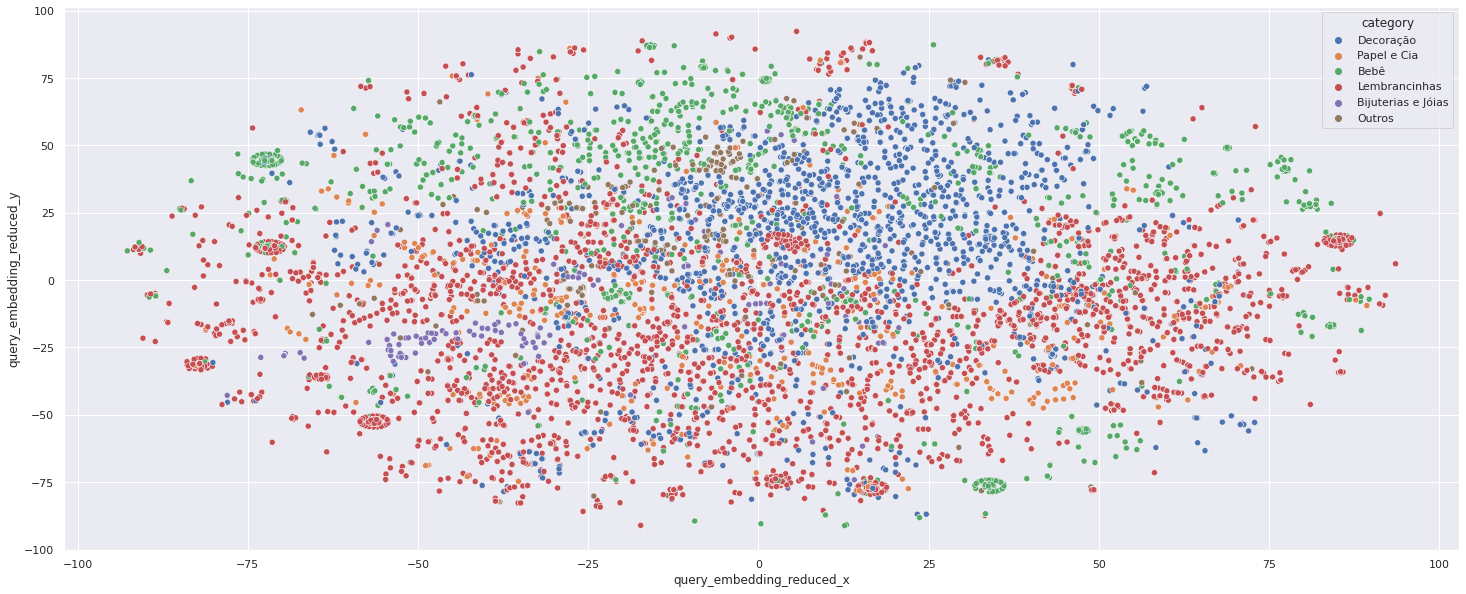

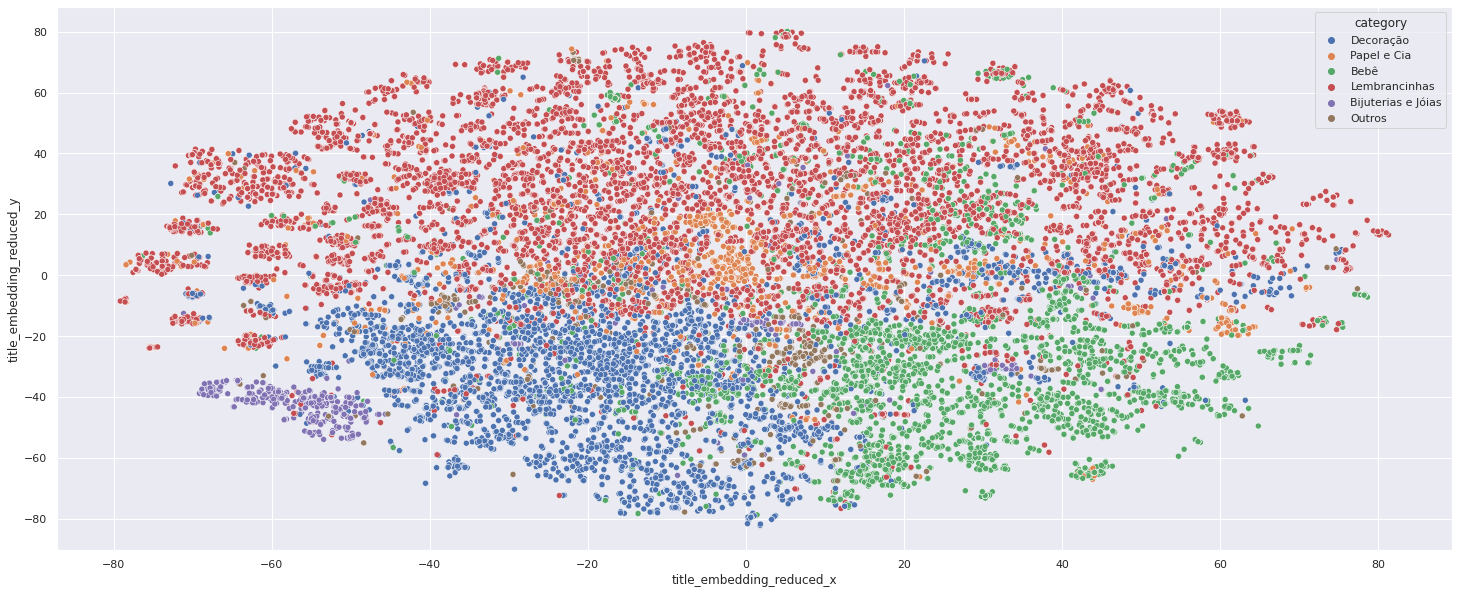

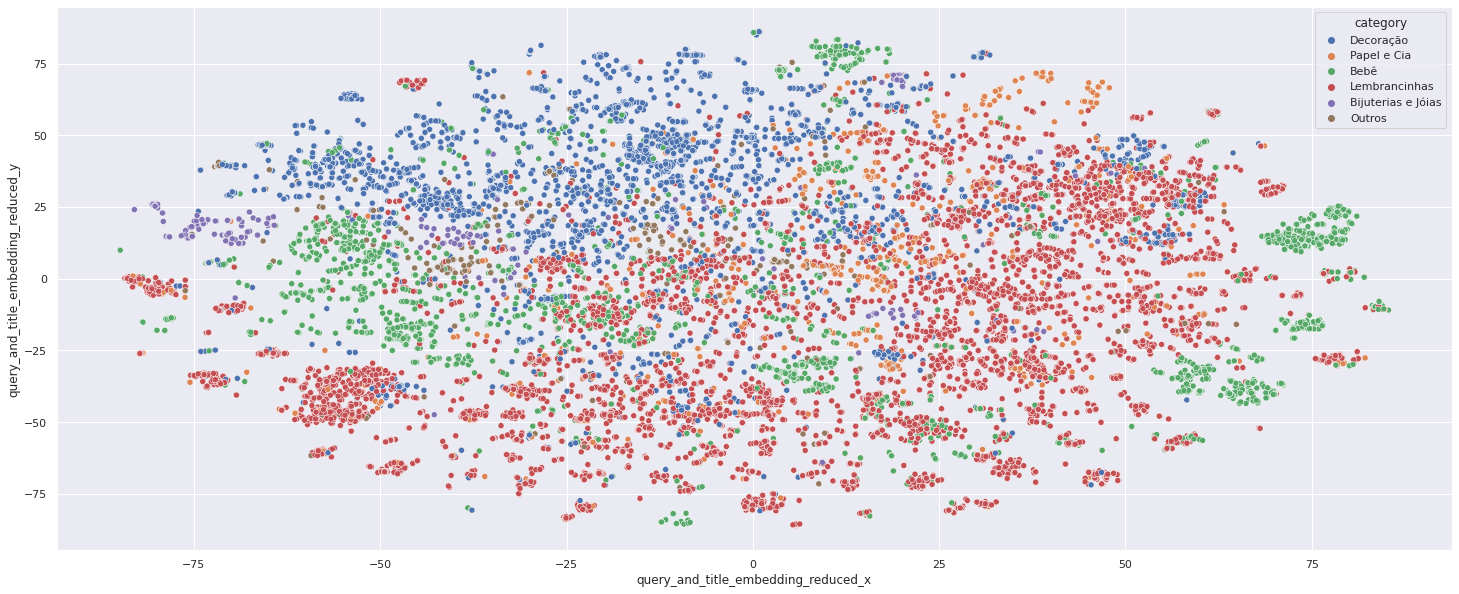

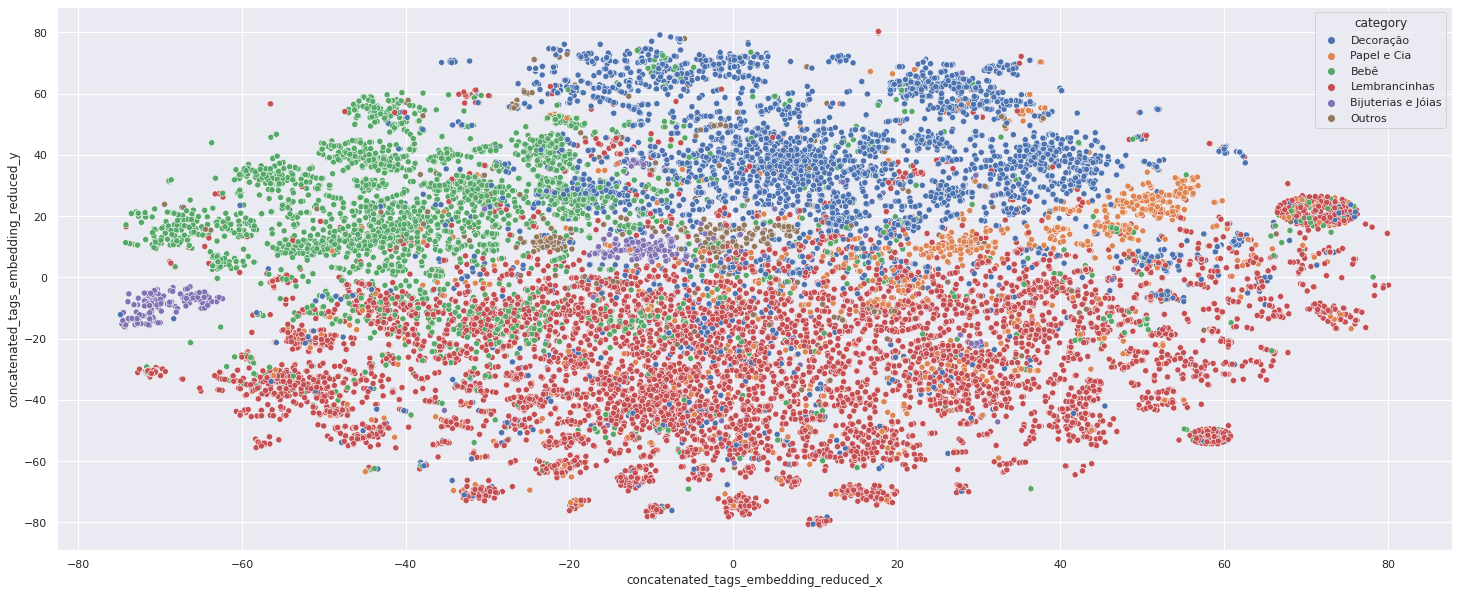

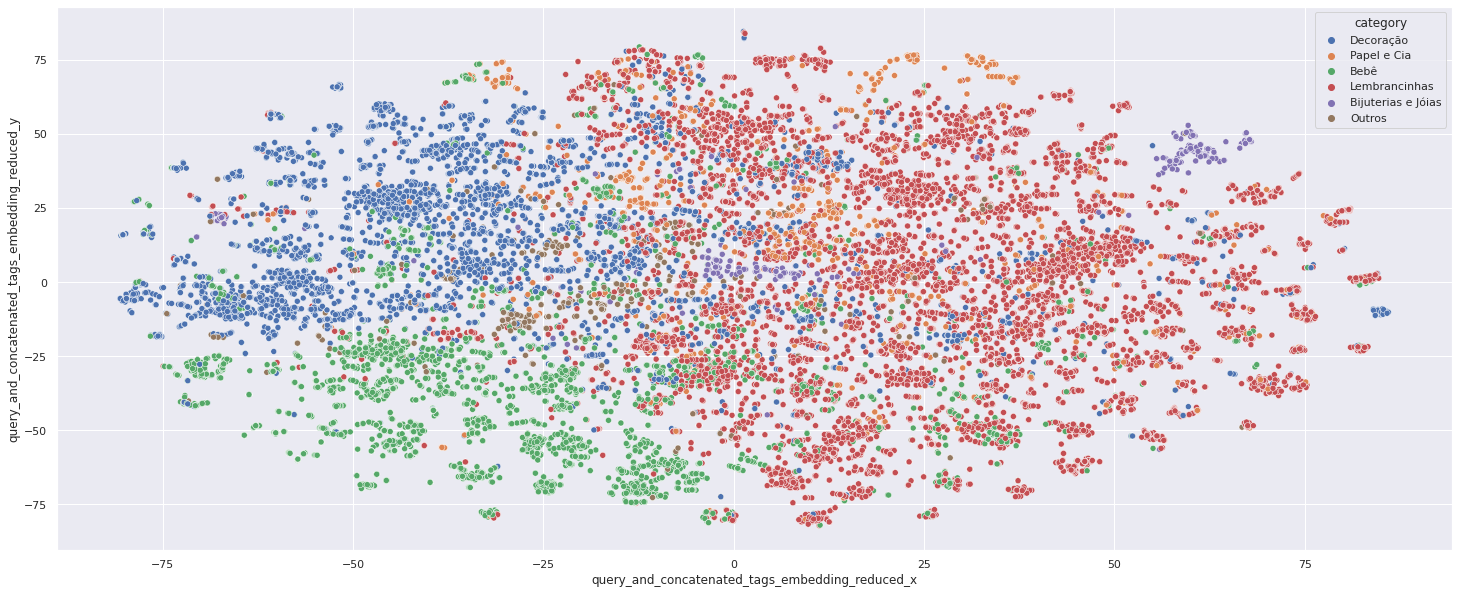

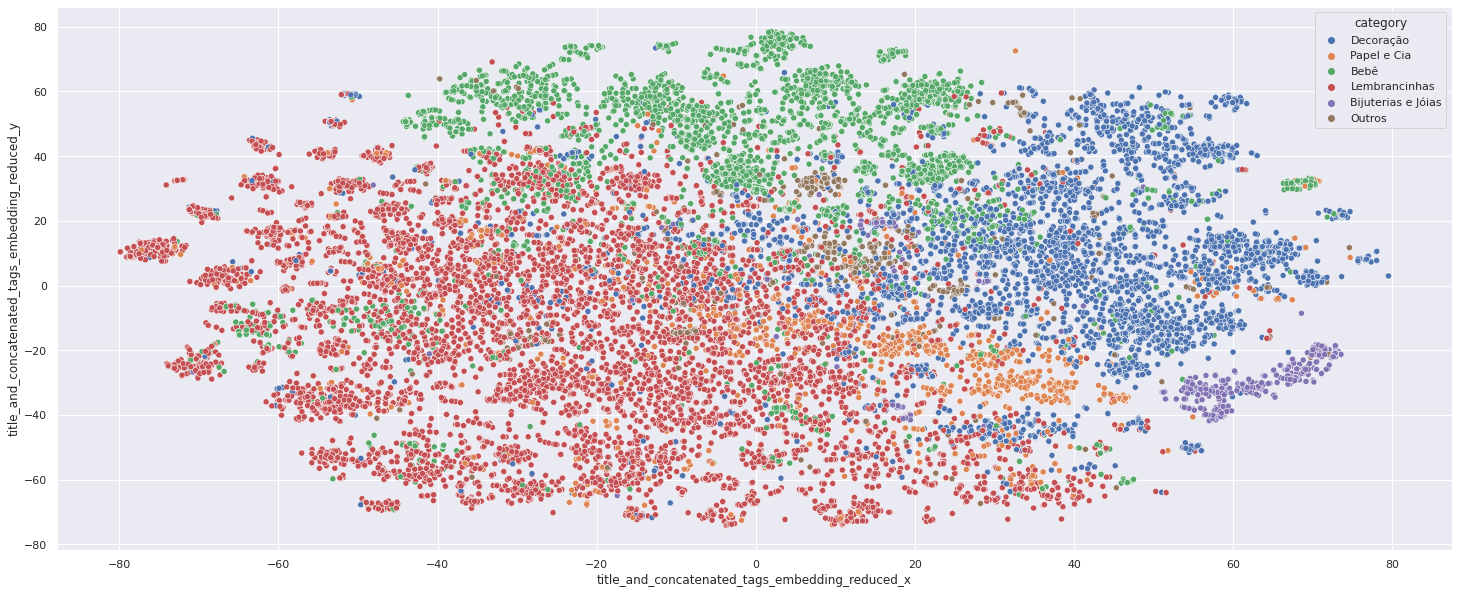

In [14]:
def plot_category_embeddings(base_frame: pd.DataFrame, x_column: str, y_column: str, title: str = None) -> None: 
    if title:
        formatted_column = ' '.join([item.capitalize() for item in title.split('_')])
        display(HTML(f'<h3>{formatted_column}</h3>'))

    g = sns.scatterplot(x=x_column, y=y_column, data=base_frame, hue="category")
    plt.show()

# Extrai a lista de colunas com embeddings criados
embeddings_columns = set([column.split('_embedding_reduced')[0]
                          for column in embeddings_frame.columns 
                          if 'embedding_reduced' in column])

# Ordena colunas extraídas por tamanho, para manter ordem de atômico para composto
embeddings_columns = sorted(embeddings_columns, key=lambda ec: len(ec))

for column in embeddings_columns:
    plot_category_embeddings(embeddings_frame,
                             f'{column}_embedding_reduced_x',
                             f'{column}_embedding_reduced_y',
                             column
                            )

Pelos gráficos, pode-se notar que *título*, *tags concatenadas* e a combinação de ambas permitem fazer agrupamento mais homogênos das categorias. Ainda há regiões em que diferentes categorias ocorrem juntas, o que pode ser pela noção de que produtos poderiam pertencer a diferentes categorias, mas a utilização desses vetores pode beneficiar o modelo de classificação.

### Análise de Potencial de Predição da Similaridade

Além de poder construir vetores de características a partir do conteúdo das colunas textuais, uma possibilidade é ver o quão bem os *embeddings* conseguiriam determinar uma categoria a partir do valor da similaridade. Para isso, é possível calcular a similaridade de um determinado valor de coluna textual com o nome de cada categoria disponível. 

In [15]:
embeddings_frame.head(2)

product_id             query  search_page  position  \
0    11394449    espirito santo            2         6   
1    15534262  cartao de visita            2         0   

                    title  \
0  Mandala Espírito Santo   
1        Cartão de Visita   

                                               concatenated_tags  \
0                                                    mandala mdf   
1  cartao visita panfletos tag adesivos copos long drink canecas   

         creation_date     category  \
0  2015-11-14 19:42:12    Decoração   
1  2018-04-04 20:55:07  Papel e Cia   

                                                                                                                                         query_embedding  \
0  [0.004229284, -0.027336909, 0.030303514, 0.069929294, 0.020897388, -0.06250459, 0.050103087, -0.058517657, -0.08247556, -0.11175527, -0.06378104, ...   
1  [-0.026694268, -0.017967489, 0.033112615, 0.014724638, -0.05641233, -0.075842515, -0.024225041, -0.01875468, 0.020485003, -0.0123114195, 0.0144400...   

                                                                                                                                         title_embedding  \
0  [-0.008050227, -0.008805177, 0.05007785, 0.052670166, -0.008375991, -0.08733791, 0.08137107, -0.047023904, -0.084045015, -0.114914, -0.015285425, ...   
1  [-0.045109227, -0.025397679, 0.03495742, 0.0006268186, -0.058263194, -0.07574056, -0.011842876, -0.024876617, 0.008490498, -0.011903388, 0.0148019...   

                                                                                                                             concatenated_tags_embedding  \
0  [-0.00096480176, 0.007755412, 0.055970505, -0.0019719256, -0.019442834, -0.06424611, -0.054305594, 0.016148726, -0.004429266, -0.011865409, 0.0453...   
1  [-0.02545547, -0.014808218, 0.03331411, 0.001733836, -0.045117356, -0.026859686, -0.040624473, -0.008041078, 0.018792158, -0.03884597, 0.044826254...   

                                                                                                                                      category_embedding  \
0  [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...   
1  [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...   

   query_embedding_reduced_x  query_embedding_reduced_y  \
0                   7.373827                  -27.02902   
1                 -17.380516                  -10.80180   

   title_embedding_reduced_x  title_embedding_reduced_y  \
0                  53.553665                  26.864161   
1                  50.474968                 -11.472339   

   concatenated_tags_embedding_reduced_x  \
0                              17.637495   
1                              36.176758   

   concatenated_tags_embedding_reduced_y  query_and_title_embedding_reduced_x  \
0                              16.003576                             9.909097   
1                             -16.469028                            15.415729   

   query_and_title_embedding_reduced_y  \
0                            -4.774183   
1                            35.624027   

   query_and_concatenated_tags_embedding_reduced_x  \
0                                        14.004797   
1                                       -14.685817   

   query_and_concatenated_tags_embedding_reduced_y  \
0                                       -29.178335   
1                                        34.873894   

   title_and_concatenated_tags_embedding_reduced_x  \
0                                         8.110390   
1                                        45.620296   

   title_and_concatenated_tags_embedding_reduced_y  
0                                         0.231442  
1                                       -34.477478

O primeiro passo é representar o nome das categorias como *embeddings*.

In [16]:
encoded_embeddings = []
for category in embeddings_frame['category'].unique().tolist():
    for column in TEXT_COLUMNS:
        embeddings = np.array(ft_model.get_sentence_vector(category.lower()))
        encoded_embeddings.append((category, column, embeddings))

category_name_embedding_frame = pd.DataFrame(encoded_embeddings, columns=['category', 'column', 'embeddings'])
display(HTML(f'<h3>Embeddings dos Registros por cada Categoria e Coluna</h3>'))
display(category_name_embedding_frame)

category             column  \
0            Decoração              query   
1            Decoração              title   
2            Decoração  concatenated_tags   
3          Papel e Cia              query   
4          Papel e Cia              title   
5          Papel e Cia  concatenated_tags   
6                 Bebê              query   
7                 Bebê              title   
8                 Bebê  concatenated_tags   
9        Lembrancinhas              query   
10       Lembrancinhas              title   
11       Lembrancinhas  concatenated_tags   
12  Bijuterias e Jóias              query   
13  Bijuterias e Jóias              title   
14  Bijuterias e Jóias  concatenated_tags   
15              Outros              query   
16              Outros              title   
17              Outros  concatenated_tags   

                                                                                                                                               embeddings  
0   [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...  
1   [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...  
2   [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...  
3   [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...  
4   [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...  
5   [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...  
6   [0.018979523, -0.040133532, 0.0026649132, -0.103634745, 0.033859685, -0.054708503, 0.020257464, 0.05290821, 0.05296137, -0.063500494, 0.038083736,...  
7   [0.018979523, -0.040133532, 0.0026649132, -0.103634745, 0.033859685, -0.054708503, 0.020257464, 0.05290821, 0.05296137, -0.063500494, 0.038083736,...  
8   [0.018979523, -0.040133532, 0.0026649132, -0.103634745, 0.033859685, -0.054708503, 0.020257464, 0.05290821, 0.05296137, -0.063500494, 0.038083736,...  
9   [0.0072319885, -0.068255894, 0.008115664, -0.035704367, -0.08738353, -0.03908668, -0.034679625, -0.002955751, 0.04695147, 0.08704281, 0.049177937,...  
10  [0.0072319885, -0.068255894, 0.008115664, -0.035704367, -0.08738353, -0.03908668, -0.034679625, -0.002955751, 0.04695147, 0.08704281, 0.049177937,...  
11  [0.0072319885, -0.068255894, 0.008115664, -0.035704367, -0.08738353, -0.03908668, -0.034679625, -0.002955751, 0.04695147, 0.08704281, 0.049177937,...  
12  [0.030716147, 0.008908771, -0.0066974135, 0.012140344, -0.016977442, -0.041606173, 0.029939262, 0.019096132, -0.014908142, 0.029624065, -0.0019034...  
13  [0.030716147, 0.008908771, -0.0066974135, 0.012140344, -0.016977442, -0.041606173, 0.029939262, 0.019096132, -0.014908142, 0.029624065, -0.0019034...  
14  [0.030716147, 0.008908771, -0.0066974135, 0.012140344, -0.016977442, -0.041606173, 0.029939262, 0.019096132, -0.014908142, 0.029624065, -0.0019034...  
15  [-0.014617172, -0.07638426, 0.030546945, -0.032391712, 0.042365387, 0.04000781, 0.036864918, 0.0059358235, -0.11796135, -0.14450769, -0.0071384436...  
16  [-0.014617172, -0.07638426, 0.030546945, -0.032391712, 0.042365387, 0.04000781, 0.036864918, 0.0059358235, -0.11796135, -0.14450769, -0.0071384436...  
17  [-0.014617172, -0.07638426, 0.030546945, -0.032391712, 0.042365387, 0.04000781, 0.036864918, 0.0059358235, -0.11796135, -0.14450769, -0.0071384436...

A seguir, faz-se a análise de similaridade entre as representações vetoriais dos nomes das categorias com cada um dos valores das colunas textuais. Para ver o quão eficaz essa similaridade é, a categoria mais similar ao conteúdo comparado é determinada como a classe do registro. Em seguida, as "predições" de categorias são comparadas com a categoria oficial do produto, para que se possa identificar a eficácia da similaridade e o potencial preditivo de cada atributo.

In [17]:
def compute_column_category_similarity(base_embeddings_frame: pd.DataFrame, 
                                       base_categories_embeddings: pd.DataFrame, 
                                       column: str, 
                                       embeddings_column: str,
                                       apply_softmax: bool = False) -> pd.DataFrame:

    similarity_frame = base_embeddings_frame.copy()
    categories = base_embeddings_frame['category'].unique().tolist()
    similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}' for category in categories]

    similarities_list = []
    for category in categories:
        column_embeddings = np.stack(similarity_frame[f'{column}_embedding'].to_numpy(), axis=0)
        category_embedding = (base_categories_embeddings
                              .loc[lambda f: (f['category'] == category) & (f['column'] == column)]
                              [embeddings_column]
                              .iloc[0]                              
                             )
        category_embedding = np.expand_dims(category_embedding, axis=0)

        similarities_list.append(cosine_similarity(category_embedding, column_embeddings))

    if apply_softmax:
        similarity_frame[similarity_columns] = softmax(np.concatenate(similarities_list, axis=0), axis=0).T
    else:
        similarity_frame[similarity_columns] = np.concatenate(similarities_list, axis=0).T

    return similarity_frame

# Criar índices e indice invertido de posição e categoria 
category_indexes = {item:i for i, item in enumerate(embeddings_frame['category'].unique().tolist())}
inverted_category_indexes = {v:k for k, v in category_indexes.items()}

# Compor nome da coluna de similaridade para cada categoria
similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}'
                          for category in embeddings_frame['category'].unique().tolist()]

predictions_by_category_name = []

for selected_column in TEXT_COLUMNS:

    # Calcular similaridades, indenficar o maior valor e o índice do maior valor de similaridade entre categorias
    similarity_frame = compute_column_category_similarity(embeddings_frame, 
                                                          category_name_embedding_frame,
                                                          selected_column,
                                                          'embeddings',
                                                          apply_softmax=False)
    similarity_frame = (similarity_frame
                        .assign(max_sim=lambda f: f[similarity_columns].apply(np.max, axis=1))
                        .assign(pred=lambda f: f[similarity_columns].apply(np.argmax, axis=1))
                       )

    # Formatar e apresentar resultados
    display(HTML(f'<h3><strong>{" ".join([item.capitalize() for item in selected_column.split("_")])}</strong></h3>'))
    display(similarity_frame
     [['title', selected_column, 'category', 'max_sim', 'pred'] + similarity_columns]
     .sample(10)
     .sort_values(by='max_sim', ascending=False)
    )

    # Calcular métricas de classificação multiclass usando a categoria com maior similaridade
    classification_metrics = compute_multiclass_classification_metrics(
        similarity_frame['category'].map(category_indexes),
        similarity_frame['pred']
    )
    
    # Calcular média da métricas aplicadas entre as categorias, para ter métrica global
    metrics_frame = (pd.DataFrame(classification_metrics)
                     .assign(category=lambda f: f.index.map(inverted_category_indexes))
                     .assign(features=selected_column)
                    )
    predictions_by_category_name.append(metrics_frame)

    display_side_by_side(
        [metrics_frame, pd.DataFrame(metrics_frame.drop(columns=['category']).mean(axis=0)).T],
        ['Métricas por Categoria', 'Média das Métricas']
    )
    

title  \
15412                Tag lembrancinha marinheiro   
10057               copo long drink os incriveis   
28439               Poster / Quadro Longe se vai   
568    cofrinhos personalizados Jardim Encantado   
16425                          Convite Formatura   
11872             Barroco Multicolor 200g - 9563   
273                                 caneca dupla   
24488            Cesto Organizador de brinquedos   
15429           APLIQUE NOME ESPELHADO PARA LAÇO   
146                         Porta Laços e Tiaras   

                                 query       category   max_sim  pred  \
15412          lembrancinha marinheiro    Papel e Cia  0.625192     3   
10057        lembrancinha os incriveis  Lembrancinhas  0.609650     3   
28439              painel dia dos pais      Decoração  0.488852     5   
568    personalizados jardim encantado  Lembrancinhas  0.476611     0   
16425                convite formatura    Papel e Cia  0.429034     3   
11872                   croche barroco         Outros  0.382838     4   
273                             caneca  Lembrancinhas  0.361214     0   
24488                cesto organizador      Decoração  0.330510     2   
15429       nome em acrilico espelhado  Lembrancinhas  0.329410     1   
146                         porta laco           Bebê  0.284240     0   

       similarity_decoração  similarity_papel_e_cia  similarity_bebê  \
15412              0.416727                0.225057         0.426466   
10057              0.326250                0.328560         0.211095   
28439              0.288600                0.310777         0.406794   
568                0.476611                0.275270         0.400096   
16425              0.305021                0.261342         0.209698   
11872              0.366409                0.168056         0.275605   
273                0.361214                0.186254         0.226856   
24488              0.255208                0.258419         0.330510   
15429              0.277454                0.329410         0.179782   
146                0.284240                0.273421         0.209047   

       similarity_lembrancinhas  similarity_bijuterias_e_jóias  \
15412                  0.625192                       0.228779   
10057                  0.609650                       0.362875   
28439                  0.280546                       0.199194   
568                    0.412263                       0.364625   
16425                  0.429034                       0.163275   
11872                  0.304445                       0.382838   
273                    0.347460                       0.196851   
24488                  0.272270                       0.290727   
15429                  0.262438                       0.328722   
146                    0.269188                       0.247591   

       similarity_outros  
15412           0.075708  
10057           0.392955  
28439           0.488852  
568             0.226306  
16425           0.105659  
11872           0.064759  
273             0.024840  
24488           0.149632  
15429           0.184015  
146             0.094040

title  \
5083      Porta Guardanapo em mdf Cru Para Mesas Festas   
30026   lustre balão infantil luminária pendente ovelha   
5351   Lustre Pendente Metal Corda Vintage Loft 6 bocas   
31873                        Tapete redondo para quarto   
17843            Letras Decorativas Com Base Mdf Crú CB   
7077                                Caixa para Afilhado   
18474             Mini chopp abridor de garrafa com imã   
16116                 Conjunto Placas para sala | 5 pçs   
11593                      Porta certidão de nascimento   
22902          Copo Twister 500ml Personalizado S/Tampa   

                                                  title       category  \
5083      Porta Guardanapo em mdf Cru Para Mesas Festas      Decoração   
30026   lustre balão infantil luminária pendente ovelha           Bebê   
5351   Lustre Pendente Metal Corda Vintage Loft 6 bocas      Decoração   
31873                        Tapete redondo para quarto           Bebê   
17843            Letras Decorativas Com Base Mdf Crú CB      Decoração   
7077                                Caixa para Afilhado  Lembrancinhas   
18474             Mini chopp abridor de garrafa com imã  Lembrancinhas   
16116                 Conjunto Placas para sala | 5 pçs      Decoração   
11593                      Porta certidão de nascimento           Bebê   
22902          Copo Twister 500ml Personalizado S/Tampa  Lembrancinhas   

        max_sim  pred  similarity_decoração  similarity_papel_e_cia  \
5083   0.555464     3              0.514224                0.400652   
30026  0.520845     0              0.520845                0.310005   
5351   0.483209     0              0.483209                0.272446   
31873  0.454589     2              0.433905                0.338581   
17843  0.438571     1              0.409754                0.438571   
7077   0.396105     2              0.318103                0.337039   
18474  0.377906     4              0.289828                0.354204   
16116  0.359803     4              0.315415                0.279540   
11593  0.358739     2              0.275451                0.312348   
22902  0.320430     3              0.307406                0.264524   

       similarity_bebê  similarity_lembrancinhas  \
5083          0.315522                  0.555464   
30026         0.412242                  0.368489   
5351          0.301995                  0.274137   
31873         0.454589                  0.293908   
17843         0.219089                  0.403085   
7077          0.396105                  0.386747   
18474         0.276607                  0.369215   
16116         0.214657                  0.338388   
11593         0.358739                  0.269624   
22902         0.318675                  0.320430   

       similarity_bijuterias_e_jóias  similarity_outros  
5083                        0.478116           0.234703  
30026                       0.301309           0.134490  
5351                        0.424857           0.145100  
31873                       0.275054           0.194350  
17843                       0.432076           0.234235  
7077                        0.244881           0.253595  
18474                       0.377906           0.208742  
16116                       0.359803           0.234136  
11593                       0.247648           0.130134  
22902                       0.243421           0.121700

title  \
29088                 Lembrancinha Maternidade   
6542            Cartao Letreiro - Dia dos Pais   
19033              Caixa Milk Ursinha Princesa   
25151  alça bolsa preto com ferragens completa   
2077                               Arte folder   
5464                  Caneta Ovelha - Embalada   
11820                    Lembrancinha batizado   
26336          Porta Guardanapo de Croche Flôr   
7325                   Kit Dia dos Professores   
18027                 Topo scrap Miga sua Loca   

                                                             concatenated_tags  \
29088  varias festas caixa batizado crisma lembrancinhas maternidade theo bebe   
6542                                                     cartoes convites tags   
19033                                ursinha ursinha princesa ideias cha laura   
25151                  acessorio bolsa alcas bolsas diversos modelos materiais   
2077                                                            artes digitais   
5464                                                      caneta personalizada   
11820                               batizado batizado miguel batizado henrique   
26336                                              porta copo porta guardanapo   
7325                                                           dia professores   
18027                                                                miga loca   

            category   max_sim  pred  similarity_decoração  \
29088           Bebê  0.698328     3              0.465851   
6542     Papel e Cia  0.545365     3              0.310140   
19033  Lembrancinhas  0.506329     3              0.435721   
25151         Outros  0.503051     4              0.357947   
2077     Papel e Cia  0.442950     4              0.309606   
5464   Lembrancinhas  0.380544     3              0.347475   
11820  Lembrancinhas  0.369931     2              0.186427   
26336      Decoração  0.353861     0              0.353861   
7325   Lembrancinhas  0.330173     5              0.166673   
18027  Lembrancinhas  0.222756     1              0.196655   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
29088                0.291064         0.540868                  0.698328   
6542                 0.247580         0.101433                  0.545365   
19033                0.291429         0.486820                  0.506329   
25151                0.291997         0.235962                  0.428377   
2077                 0.282177         0.188123                  0.364683   
5464                 0.329876         0.262004                  0.380544   
11820                0.131292         0.369931                  0.294319   
26336                0.252329         0.274946                  0.318168   
7325                 0.224591         0.286573                  0.248452   
18027                0.222756         0.099176                  0.159315   

       similarity_bijuterias_e_jóias  similarity_outros  
29088                       0.378022           0.209776  
6542                        0.346099           0.352098  
19033                       0.302745           0.100724  
25151                       0.503051           0.478246  
2077                        0.442950           0.268836  
5464                        0.280800           0.118921  
11820                       0.060137           0.030249  
26336                       0.270947           0.128977  
7325                        0.157066           0.330173  
18027                       0.143289           0.063257

Pela avaliação superficial desse classificador ingênuo, título e consulta teriam um desempenho próximo, com aproximadamente 0.35 de precisão e F1, enquanto a concatenação das *tags* teria a eficácia maior, com 0.38 de precisão e 0.40 de F1. 

Algo recorrente que pôde ser observado no conjunto de dados é não concordância entre *tags* e categorias. Na tabela abaixo, é possível observar casos em que a categoria é diferente de 'Lembrancinhas', mas a única *tag* associada ao produto indica exatamente o conteúdo 'Lembrancinhas'. Ainda que isso seja incoerente do ponto de vista de categorização, para o vendedor faz sentido aplicar uma *tag* diferente da categoria para ampliar a possibilidade de seu produto casar com termos de busca de clientes.

In [18]:
(similarity_frame
 [['concatenated_tags', 'category', 'max_sim']]
 .sort_values(by='max_sim', ascending=False)
 .head()
)

concatenated_tags       category  max_sim
17623     lembrancinhas  Lembrancinhas      1.0
13979     lembrancinhas    Papel e Cia      1.0
9554      lembrancinhas           Bebê      1.0
16003     lembrancinhas  Lembrancinhas      1.0
4955      lembrancinhas           Bebê      1.0

Para tentar evitar uma dependência mais direta e essencialmente sintática entre categoria e as demais colunas textuais, a seguir é feita uma tentativa de generalização do conteúdo de cada categoria. Para isso, usa-se como *embeddings* da categoria não o nome da categoria, mas a média dos *embeddings* dos produtos que pertencem a ela.

In [19]:
encoded_embeddings = []
for category in embeddings_frame['category'].unique().tolist():
    for column in TEXT_COLUMNS:
        embeddings = np.stack(embeddings_frame
                              .loc[lambda f: f['category'] == category]
                              [f'{column}_embedding']
                              .to_numpy(),
                              axis=0)
        encoded_embeddings.append((category, column, np.mean(embeddings, axis=0)))        

average_embedding_frame = pd.DataFrame(encoded_embeddings, columns=['category', 'column', 'averaged_embeddings'])
display(HTML(f'<h3>Média dos Embeddings dos Registros por cada Categoria e Coluna</h3>'))
average_embedding_frame

category             column  \
0            Decoração              query   
1            Decoração              title   
2            Decoração  concatenated_tags   
3          Papel e Cia              query   
4          Papel e Cia              title   
5          Papel e Cia  concatenated_tags   
6                 Bebê              query   
7                 Bebê              title   
8                 Bebê  concatenated_tags   
9        Lembrancinhas              query   
10       Lembrancinhas              title   
11       Lembrancinhas  concatenated_tags   
12  Bijuterias e Jóias              query   
13  Bijuterias e Jóias              title   
14  Bijuterias e Jóias  concatenated_tags   
15              Outros              query   
16              Outros              title   
17              Outros  concatenated_tags   

                                                                                                                                      averaged_embeddings  
0   [-0.007964056, -0.014651332, 0.038455818, 0.01766196, -0.019800413, -0.05913129, -0.00073482434, -0.006100115, 0.012117426, -0.042138804, 0.023452...  
1   [-0.004499731, -0.011117094, 0.039307337, 0.0087564085, -0.014077116, -0.056779742, 0.000126013, -0.007247141, 0.00651129, -0.03627611, 0.01994321...  
2   [-0.003190069, -0.0072633135, 0.04421958, 0.019958705, -0.022145906, -0.05130182, -0.0014365015, -0.0067820707, 0.009300181, -0.04913421, 0.033625...  
3   [-0.018732795, -0.034160767, 0.031822205, 0.00013541491, -0.014886948, -0.06099686, -0.018668389, -0.011273392, 0.0061525726, -0.04201865, 0.01188...  
4   [-0.015145668, -0.028174656, 0.032744106, 5.9342045e-05, -0.014411121, -0.056480847, -0.015982574, -0.011586429, 0.0010866959, -0.035746813, 0.008...  
5   [-0.019253427, -0.031899285, 0.038944308, -0.0004987191, -0.022371858, -0.051442973, -0.021818992, -0.012410783, 0.0008249664, -0.04216691, 0.0213...  
6   [-0.0087795565, -0.03314465, 0.03674917, -0.014080777, -0.011695282, -0.06567188, 0.008216412, -0.014336072, 0.018310852, -0.046924997, 0.01165069...  
7   [-0.0073604425, -0.024197565, 0.036609806, -0.01523442, -0.0138698295, -0.059848763, 0.0077545196, -0.01129135, 0.00907282, -0.041313305, 0.011608...  
8   [-0.0039862837, -0.028009303, 0.03580334, -0.016909296, -0.01588895, -0.05017016, 0.007285881, -0.01181218, 0.022165973, -0.045713436, 0.02822259,...  
9   [-0.017055836, -0.03519711, 0.027647054, -0.017203981, -0.015325613, -0.04968543, -0.0066670375, -0.0145172365, 0.02349838, -0.03376357, 0.0094938...  
10  [-0.019107373, -0.032837156, 0.031193515, -0.016760847, -0.011787891, -0.051410615, -0.007494227, -0.015155565, 0.018061334, -0.035386745, 0.00935...  
11  [-0.017429171, -0.028819654, 0.032151338, -0.015874082, -0.018296452, -0.042937644, -0.005982747, -0.013096246, 0.021520954, -0.033662267, 0.02036...  
12  [-0.0038209166, -0.04604494, 0.027318906, -0.0012207765, -0.029347682, -0.052213088, 0.009443185, 0.016198652, 0.0051921885, -0.041516084, 0.02527...  
13  [-0.0015582911, -0.026164884, 0.035279237, 0.0014471235, -0.019884564, -0.05579568, 0.011767248, 0.010612631, -0.0002484724, -0.034101512, 0.02079...  
14  [0.00052918197, -0.034913577, 0.031923138, 0.0020718088, -0.032644596, -0.039635308, 0.011054089, 0.019549584, 0.00033726598, -0.037580993, 0.0277...  
15  [-0.007516479, -0.040242624, 0.034904268, -0.0035694712, -0.020783562, -0.048479754, -0.007302867, -0.0130349, 0.01363995, -0.03901185, 0.00965969...  
16  [-0.007872141, -0.02988408, 0.036828358, -0.0016022709, -0.016604465, -0.046406545, -0.0031431727, -0.011842724, 0.003404722, -0.03532482, 0.00846...  
17  [-0.006706863, -0.036492076, 0.04244292, -0.0011504192, -0.02528769, -0.036502734, -0.005838739, -0.013257201, 0.0048519433, -0.038909223, 0.01967...

In [20]:
# Criar índices e indice invertido de posição e categoria 
category_indexes = {item:i for i, item in enumerate(embeddings_frame['category'].unique().tolist())}
inverted_category_indexes = {v:k for k, v in category_indexes.items()}

# Compor nome da coluna de similaridade para cada categoria
similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}'
                          for category in embeddings_frame['category'].unique().tolist()]

predictions_by_category_content = []
for selected_column in TEXT_COLUMNS:

    # Calcular similaridades, indenficar o maior valor e o índice do maior valor de similaridade entre categorias
    similarity_frame = compute_column_category_similarity(embeddings_frame, 
                                                          average_embedding_frame,
                                                          selected_column, 
                                                          'averaged_embeddings',
                                                          apply_softmax=False)
    similarity_frame = (similarity_frame
                        .assign(max_sim=lambda f: f[similarity_columns].apply(np.max, axis=1))
                        .assign(pred=lambda f: f[similarity_columns].apply(np.argmax, axis=1))
                       )

    # Formatar e apresentar resultados
    display(HTML(f'<h3><strong>{" ".join([item.capitalize() for item in selected_column.split("_")])}</strong></h3>'))
    display(similarity_frame
     [['title', selected_column, 'category', 'max_sim', 'pred'] + similarity_columns]
     .sample(10)
     .sort_values(by='max_sim', ascending=False)
    )

    # Calcular métricas de classificação multiclass usando a categoria com maior similaridade
    classification_metrics = compute_multiclass_classification_metrics(
        similarity_frame['category'].map(category_indexes),
        similarity_frame['pred']
    )

    # Calcular média da métricas aplicadas entre as categorias, para ter métrica global
    metrics_frame = (pd.DataFrame(classification_metrics)
                     .assign(category=lambda f: f.index.map(inverted_category_indexes))
                     .assign(features=selected_column)
                    )
    predictions_by_category_content.append(metrics_frame)
    
    display_side_by_side(
        [metrics_frame, pd.DataFrame(metrics_frame.drop(columns=['category']).mean(axis=0)).T],
        ['Métricas por Categoria', 'Média das Métricas']
    )

title  \
29934         Quadro Artesanal Casal Deitado 70x100 ( C09 - CL)   
22914                         Tag - Lembrancinha de maternidade   
17265                 Lembrancinha Maternidade com urso pelúcia   
5545                                      Trilho de mesa floral   
5108                                      Tubete Branca de Neve   
11147  Espelho Decorativo Abstrato Acrílico Sala Quarto | AB12M   
29388                          Lembrancinha Chá de Bebê Meninos   
10897                              Squeeze Personalizada Frozen   
5549                    Pirulito de marshmallow princesa frozen   
5425                         TUBETE LATINHAS GARRAFINHAS FROZEN   

                                          query       category   max_sim  \
29934  quadros decorativos para quarto de casal      Decoração  0.796997   
22914      tag para lembrancinha de maternidade    Papel e Cia  0.765293   
17265                  lembrancinha maternidade  Lembrancinhas  0.749177   
5545                   trilho de mesa de croche      Decoração  0.720935   
5108                lembrancinha branca de neve  Lembrancinhas  0.714156   
11147                espelho grande para quarto      Decoração  0.713305   
29388      lembrancinhas de cha de bebe baratas           Bebê  0.705614   
10897                      lembrancinhas frozen  Lembrancinhas  0.691499   
5549                  decoracao com marshmallow  Lembrancinhas  0.682897   
5425                                     frozen  Lembrancinhas  0.404357   

       pred  similarity_decoração  similarity_papel_e_cia  similarity_bebê  \
29934     0              0.796997                0.685388         0.654438   
22914     3              0.643016                0.738478         0.756006   
17265     2              0.507103                0.612567         0.749177   
5545      0              0.720935                0.571829         0.600057   
5108      3              0.668547                0.656488         0.656547   
11147     0              0.713305                0.638585         0.614779   
29388     3              0.636127                0.630855         0.687780   
10897     3              0.471485                0.571598         0.552555   
5549      3              0.654853                0.655431         0.639315   
5425      3              0.287892                0.336399         0.337333   

       similarity_lembrancinhas  similarity_bijuterias_e_jóias  \
29934                  0.657728                       0.534488   
22914                  0.765293                       0.540801   
17265                  0.744323                       0.457606   
5545                   0.551193                       0.530917   
5108                   0.714156                       0.585039   
11147                  0.600460                       0.519927   
29388                  0.705614                       0.506742   
10897                  0.691499                       0.391111   
5549                   0.682897                       0.553107   
5425                   0.404357                       0.228577   

       similarity_outros  
29934           0.657687  
22914           0.676372  
17265           0.559535  
5545            0.670924  
5108            0.696653  
11147           0.590570  
29388           0.670234  
10897           0.550159  
5549            0.655875  
5425            0.360955

title  \
7510    Par de Alianças 8mm banhadas a Ouro 18k   
25851      Tapete de Barbante Retangular Floral   
22116   Lembrancinha jardim encantado gaiolinha   
25759  30Lembrancinha de maternidade em biscuit   
10459   Mochilinhas Personalizadas Show da Luna   
16748              Quadro Aniversário de Namoro   
208     Aplique 15 anos Dourado Kit 10 unidades   
5319                       Passadeira em crochê   
28278                           Garrafinha Neon   
1788                  Painel do Cardápio do Dia   

                                          title            category   max_sim  \
7510    Par de Alianças 8mm banhadas a Ouro 18k  Bijuterias e Jóias  0.831071   
25851      Tapete de Barbante Retangular Floral           Decoração  0.818543   
22116   Lembrancinha jardim encantado gaiolinha       Lembrancinhas  0.742523   
25759  30Lembrancinha de maternidade em biscuit       Lembrancinhas  0.710518   
10459   Mochilinhas Personalizadas Show da Luna       Lembrancinhas  0.702039   
16748              Quadro Aniversário de Namoro           Decoração  0.652457   
208     Aplique 15 anos Dourado Kit 10 unidades       Lembrancinhas  0.648246   
5319                       Passadeira em crochê           Decoração  0.617676   
28278                           Garrafinha Neon       Lembrancinhas  0.604792   
1788                  Painel do Cardápio do Dia           Decoração  0.569737   

       pred  similarity_decoração  similarity_papel_e_cia  similarity_bebê  \
7510      4              0.604862                0.563707         0.566066   
25851     0              0.818543                0.669887         0.700266   
22116     3              0.672251                0.655328         0.694328   
25759     2              0.655919                0.619387         0.710518   
10459     3              0.620839                0.683088         0.655927   
16748     0              0.652457                0.652197         0.603284   
208       5              0.607676                0.640341         0.597631   
5319      0              0.617676                0.478673         0.540291   
28278     3              0.535246                0.545620         0.535310   
1788      0              0.569737                0.563467         0.494540   

       similarity_lembrancinhas  similarity_bijuterias_e_jóias  \
7510                   0.552031                       0.831071   
25851                  0.655516                       0.672415   
22116                  0.742523                       0.574260   
25759                  0.673723                       0.586889   
10459                  0.702039                       0.581242   
16748                  0.625181                       0.573465   
208                    0.617928                       0.596080   
5319                   0.476041                       0.513741   
28278                  0.604792                       0.508396   
1788                   0.497383                       0.425789   

       similarity_outros  
7510            0.627290  
25851           0.783308  
22116           0.658924  
25759           0.669262  
10459           0.658497  
16748           0.570527  
208             0.648246  
5319            0.594961  
28278           0.576027  
1788            0.490690

title  \
18882  Lembrancinha Batizado e Primeira comunhão   
19671                   Conjunto CARROS MC QUEEN   
1786        Imã de geladeira com calendário 2019   
17795   Copo Twister 500ml Personalizado C/Tampa   
6231     Caixa de bis personalizada Dia dos Pais   
3361                         Roupa tutu da Ariel   
22221            Chaveiro Lembrancinha de Crisma   
3346                    Fichário A4 - Cartonagem   
21945                         Colar Penduricalho   
2072                       Bolsinha Lol Surpresa   

                                                                                                    concatenated_tags  \
18882  batizado bela primeira eucaristia sabonetes batizado isadora lembrancinhas primeira comunhao diversos isabella   
19671                                                                                  roupa menino albertinho1 roupa   
1786                                                                              presentes imas geladeira calendario   
17795                                                                                               aniversario maria   
6231                                                                                                dia maes dia pais   
3361                                                                          ariel sereia ariel festa pequena sereia   
22221                                                                                                       chaveiros   
3346                                                                                           escritorio fichario a4   
21945                                                                                               ceramica plastica   
2072                                                                                 lol surprise lol ver bonecas lol   

                 category   max_sim  pred  similarity_decoração  \
18882       Lembrancinhas  0.800501     3              0.660715   
19671                Bebê  0.679968     2              0.586270   
1786        Lembrancinhas  0.670645     1              0.627339   
17795       Lembrancinhas  0.622761     3              0.412638   
6231          Papel e Cia  0.607184     3              0.459210   
3361                 Bebê  0.587529     3              0.469669   
22221       Lembrancinhas  0.583515     5              0.497997   
3346          Papel e Cia  0.535702     1              0.475113   
21945  Bijuterias e Jóias  0.531088     5              0.511328   
2072        Lembrancinhas  0.453818     3              0.401508   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
18882                0.723697         0.722424                  0.800501   
19671                0.554201         0.679968                  0.596290   
1786                 0.670645         0.554735                  0.624622   
17795                0.501446         0.531851                  0.622761   
6231                 0.564453         0.534386                  0.607184   
3361                 0.499602         0.548658                  0.587529   
22221                0.554012         0.456701                  0.530501   
3346                 0.535702         0.447004                  0.448039   
21945                0.417056         0.457225                  0.413033   
2072                 0.433946         0.442813                  0.453818   

       similarity_bijuterias_e_jóias  similarity_outros  
18882                       0.589811           0.672143  
19671                       0.532385           0.628682  
1786                        0.528328           0.630500  
17795                       0.397191           0.433894  
6231                        0.393022           0.467855  
3361                        0.493249           0.498605  
22221                       0.534563           0.583515  
3346                        0.365578           0.447203  
21945                       0.445819     

Com a troca da análise de similaridade pelo conteúdo dos itens da categoria em vez do simples nome da categoria, houve um aumento significativo da eficácia. 

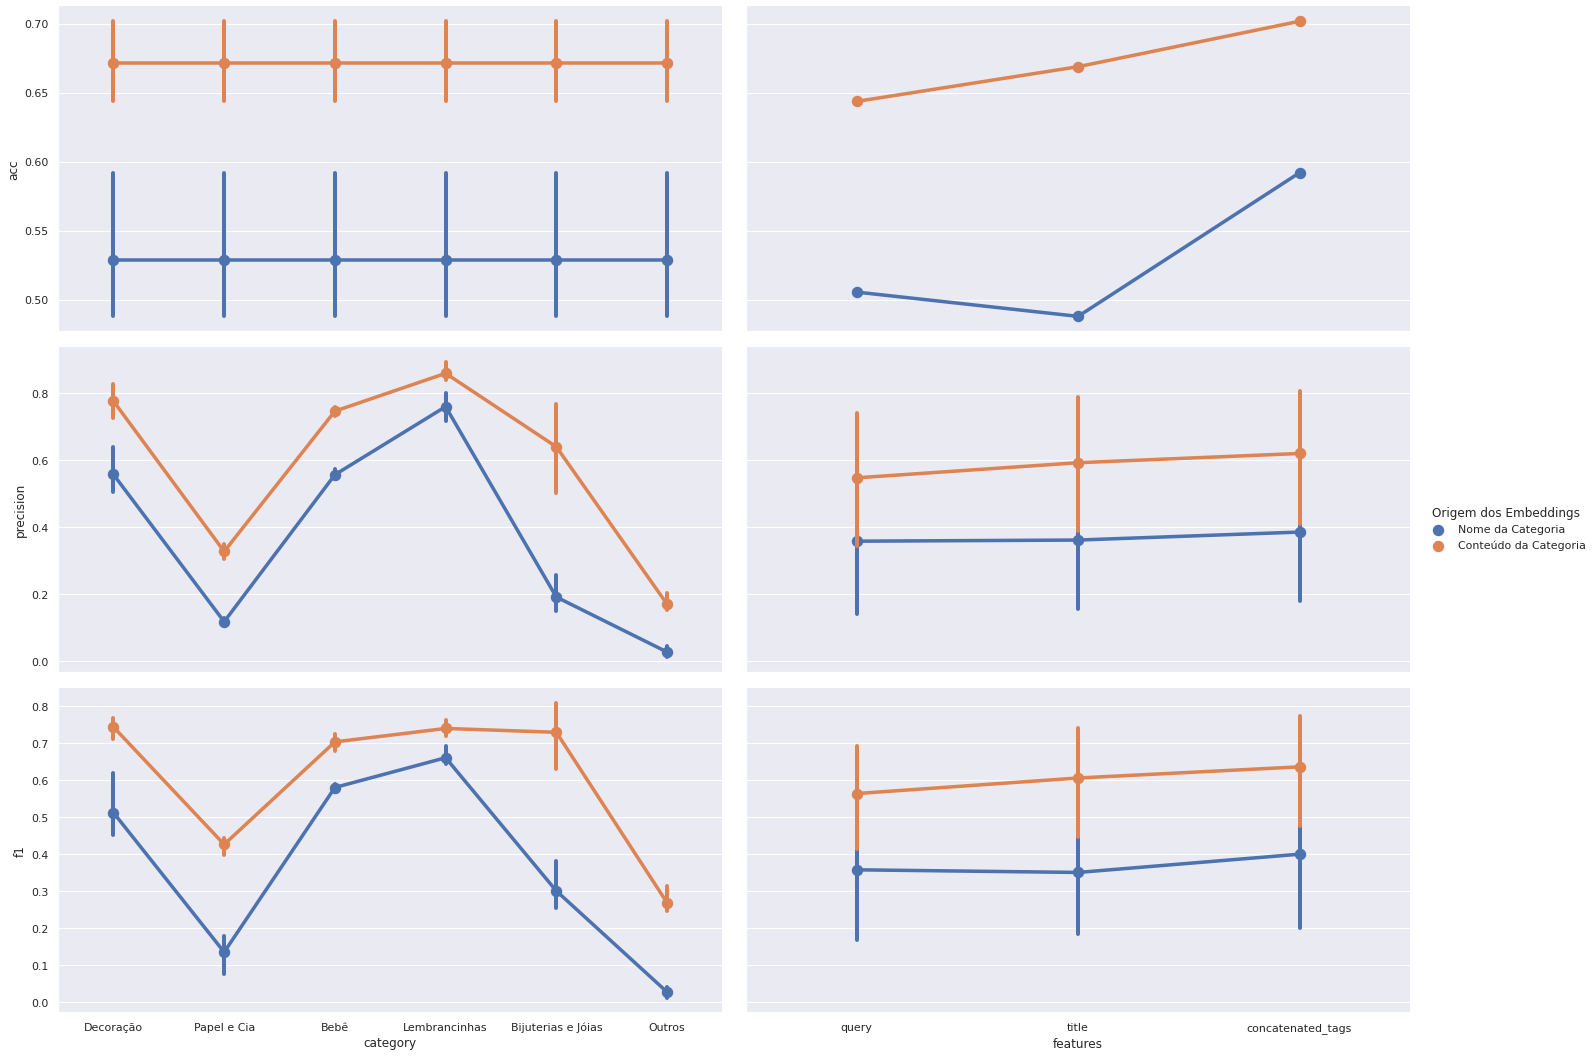

In [21]:
metrics_by_category_name = pd.concat(predictions_by_category_name, axis=0)
metrics_by_category_content = pd.concat(predictions_by_category_content, axis=0)

display(HTML('<h3>Desempenho por Estratégia de Embeddings</h3>'))
display_side_by_side([metrics_by_category_name, metrics_by_category_content], ['Baseada no Nome', 'Baseada no Conteúdo'])


g = sns.PairGrid(data=pd.concat([metrics_by_category_name.assign(group='Nome da Categoria'), 
                                 metrics_by_category_content.assign(group='Conteúdo da Categoria')]),
                 y_vars=['acc', 'precision', 'f1'], x_vars=['category', 'features'], 
                 hue='group', height=5, aspect=2
                )

g.map(sns.pointplot, scale=1.3, errwidth=4)
g.add_legend(title="Origem dos Embeddings")
plt.show()